In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load the points.

In [11]:
circle = pd.read_csv('Circle.csv', header=None, names=['x', 'y'])
spiral = pd.read_csv('Spiral.csv', header=None, names=['x', 'y', 'label'])
circle.head(), spiral.head()

(        x        y
 0  2.7147  0.81472
 1  2.8054  0.94572
 2  2.0253  0.20682
 3  2.8096  1.03310
 4  2.5257  0.79188,
        x     y  label
 0  31.95  7.95      3
 1  31.15  7.30      3
 2  30.45  6.65      3
 3  29.70  6.00      3
 4  28.90  5.55      3)

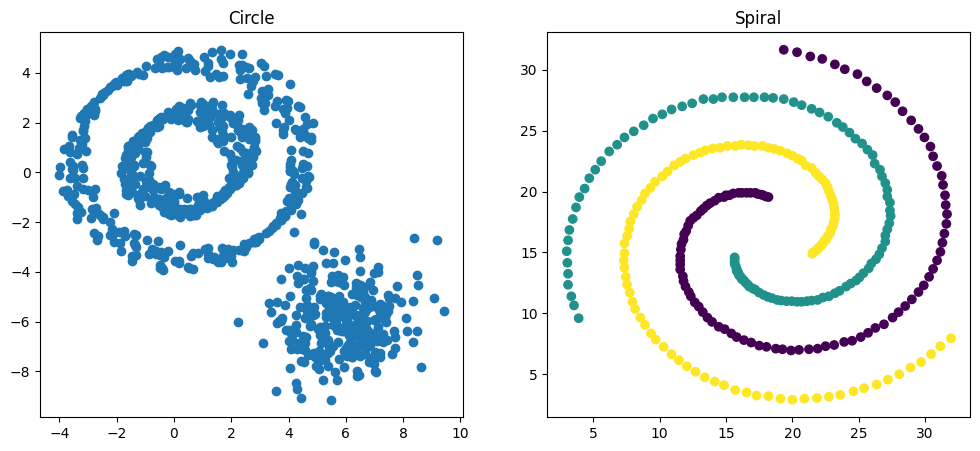

In [12]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(circle['x'],circle['y'])
ax[0].set_title('Circle')
ax[1].scatter(spiral['x'],spiral['y'],c=spiral['label'])
ax[1].set_title('Spiral')
plt.show()

In [ ]:
circle_points = circle[['x', 'y']].values
spiral_points = spiral[['x', 'y']].values

array([[ 2.7147 ,  0.81472],
       [ 2.8054 ,  0.94572],
       [ 2.0253 ,  0.20682],
       ...,
       [ 7.0303 , -8.0004 ],
       [ 5.4921 , -5.4912 ],
       [ 8.3419 , -6.8019 ]])

Define the similarity function.

In [ ]:
def similarity(x_i, x_j, sigma):
    return np.exp(-np.linalg.norm(x_i - x_j) / (2 * sigma ** 2))

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

def similarity_graph(X, k, sigma=1):        
    similarities = similarity(X, X, sigma)
    np.fill_diagonal(similarities, 0)  # diagonal elements are zero by definition
    
    # Create k-nearest neighbor graphs for each k    
    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(X)
    knn_indices = nbrs.kneighbors(X, return_distance=False)  # Indices of k-nearest
        
    # Construct the adjacency matrix W
    W = np.zeros_like(similarities)
    for i in range(len(X)):
        W[i, knn_indices[i]] = similarities[i, knn_indices[i]]    

    return W
